In [4]:
import cvxopt
from cvxopt import matrix, solvers 
import numpy as np
import kernels as kl

class DiscriminantClassifier:
    pass


class SVM(DiscriminantClassifier):
    def __init__(self, kernel, C = None):
        self.kernel = kernel
        self.C = C 
        
    def setUp(self,X,y):
        
        X_train = X.copy()
        y_train = y.copy()
        self.X = X_train
        self.y = y_train

        #self.X = np.insert(self.X, 0, values=1, axis=1)
        
        self.N,self.p = self.X.shape
        
        def _perform_convex_optimisation(self, verbose = False):
        # to do with convex opt part there are three main components:
        
        # step 1 : min xPx + Qx:
        K = self.kernel.covariance(self.X,self.X)
        T = self.y[:,np.newaxis]*self.y
        P = matrix(T*K,tc = 'd') 
        
        Q = -np.ones(self.N)
        Q = matrix(Q,tc = 'd')
        
        # step 2 : such that Gx < h:
        if self.C is None:
            G = -np.eye(self.N)
            G = matrix(G,tc='d')
            h = np.zeros(self.N)
            h = matrix(h, tc = 'd')
        else:
            G_top = np.eye(self.N)
            G_bottom = -np.eye(self.N)
            G = np.concatenate([G_top, G_bottom ],0)
            G = matrix(G,tc='d')
            h_top = np.ones(self.N)*self.C
            h_bottom = np.zeros(self.N)
            h = np.concatenate([h_top, h_bottom ],0)
            h = matrix(h, tc = 'd')
        
        # step 3 : and Ax = b:
        A = matrix(self.y.reshape(1,-1), tc = 'd')
        b = matrix(0, tc = 'd')
        
        if verbose:
            cvxopt.solvers.options['show_progress'] = True
        else:
            cvxopt.solvers.options['show_progress'] = False
            
        minima = cvxopt.solvers.qp(P, Q, G, h, A, b)
        return minima
    
    
    def _create_support_data(self, minima, eps = 10e-11):
        self.all_lagrangian_multipliers = np.array(minima['x'])
        self.support_indices = np.array(self.all_lagrangian_multipliers) > eps
        self.support_indices = self.support_indices.reshape(1,-1).ravel()


        self.support_multipliers = self.all_lagrangian_multipliers[self.support_indices].ravel()
        self.support_vectors = self.X[self.support_indices]
        self.support_output = self.y[self.support_indices]
        
        self.K_support = self.kernel.covariance(self.support_vectors, self.support_vectors)
        
        
    def get_support_data(self):
        
        return {'lagrangian_multipliers': self.support_multipliers,\
                'support_vectors':self.support_vectors, 'support_output':self.support_output,\
                'support_kernel_matrix':  self.K_support, 'intercept':self.intercept}
        
        
        
    def fit(self, X, y, verbose = False, eps = 10e-11):
        self.setUp(X,y)
        minima = self._perform_convex_optimisation(verbose)
        self._create_support_data(minima)
        
        amtm = np.multiply(self.support_multipliers, self.support_output)
        self.intercept = np.mean(self.support_output - np.matmul(amtm, self.K_support))
        
    
    def predict_value(self, X):
        res = 0
        for i in range(0,len(self.support_multipliers)):
            res += self.support_multipliers[i]*self.support_output[i]\
            *self.kernel.covariance(X,self.support_vectors[i])
        res+=self.intercept
        
        return res
    
    def predict(self, X):
        values = self.predict_value(X)
        return np.array([np.sign(val) for val in values])
        
    

In [35]:
X = np.random.normal(0,10,(150,2))
Y = np.sum(X,1)
Z = np.array(Y > 0,int)
W = np.array(Y<0,int)
Y = Z - W


N,p = X.shape
split = int(0.8*N)
X_train, X_val = X[:split], X[split:]
y_train, y_val = Y[:split], Y[split:]




kernel = kl.SquareExponential(0.9,0.8)
svm = SVM(kernel = kernel, C = 1)
svm.fit(X_train,y_train)
training_acc = sum(svm.predict(X_train) == y_train.reshape(-1,1))/len(y_train)

print(training_acc)


validation_acc = sum(svm.predict(X_val) == y_val.reshape(-1,1))/len(y_val)

print(validation_acc)


[1.]
[0.6]


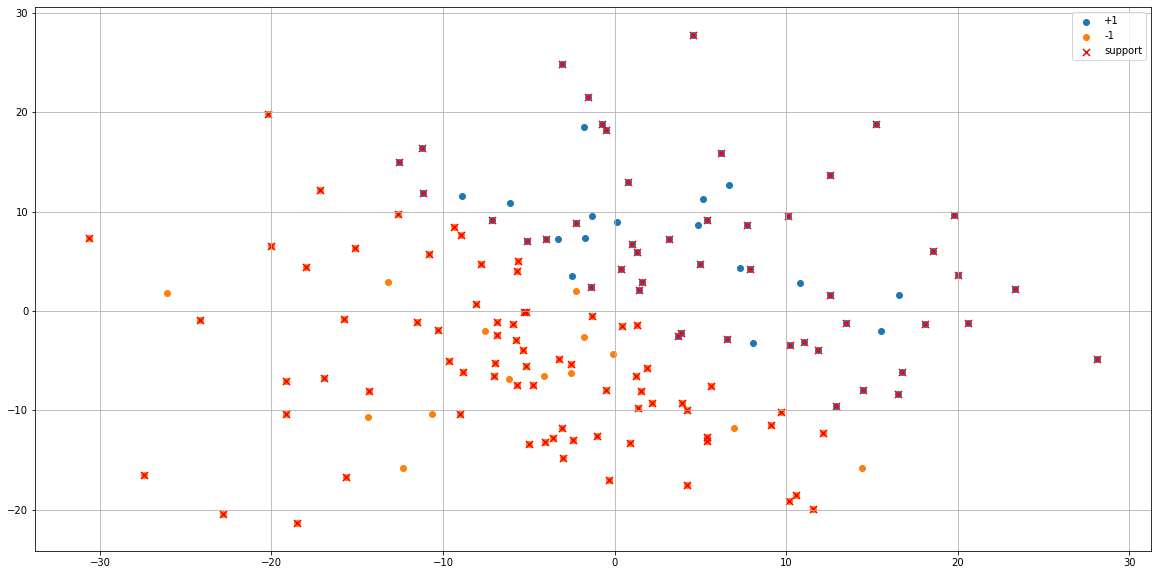

In [43]:

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

X1 = X[Y==1]
X2 = X[Y==-1]
plt.scatter(X1.T[0],X1.T[1], label = '+1')
plt.scatter(X2.T[0],X2.T[1], label = '-1')

support_data = svm.get_support_data()

s1, s2 = support_data['support_vectors'].T

plt.scatter(s1,s2, marker = 'x', color = 'r', label = 'support', s=50)
#plt.scatter(new_point[0][0],new_point[0][1], label = 'new_point : '+ str(sign))

plt.grid()
plt.legend()
plt.show()



In [ ]:
# we can make the boundary a little more clearer

In [61]:
X_plus = np.random.normal(0,10,(100,2))
X_minus = np.random.normal(40,10,(100,2))

Y_plus = np.ones(100)
Y_minus = -np.ones(100)

X = np.concatenate([X_plus, X_minus])
Y = np.concatenate([Y_plus, Y_minus])

idx = np.arange(0,len(X))
np.random.shuffle(idx)
X = X[idx]
Y = Y[idx]


N,p = X.shape
split = int(0.8*N)
X_train, X_val = X[:split], X[split:]
y_train, y_val = Y[:split], Y[split:]




kernel = kl.SquareExponential(0.9,0.8)
svm = SVM(kernel = kernel, C = 1)
svm.fit(X_train,y_train)
training_acc = sum(svm.predict(X_train) == y_train.reshape(-1,1))/len(y_train)

print(training_acc)


validation_acc = sum(svm.predict(X_val) == y_val.reshape(-1,1))/len(y_val)

print(validation_acc)

[1.]
[0.725]


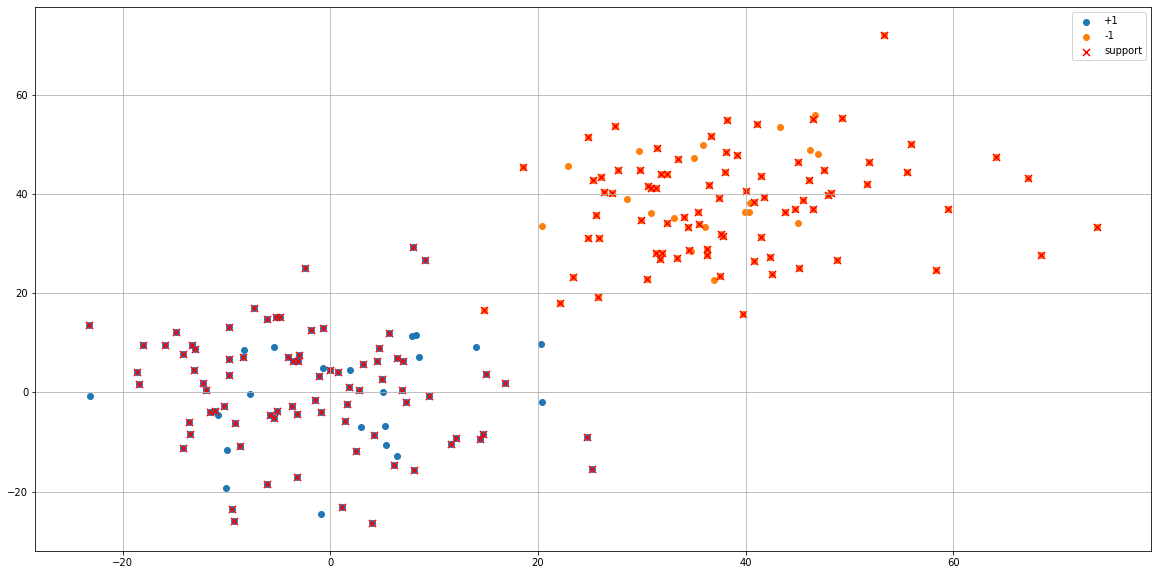

In [62]:

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

X1 = X[Y==1]
X2 = X[Y==-1]
plt.scatter(X1.T[0],X1.T[1], label = '+1')
plt.scatter(X2.T[0],X2.T[1], label = '-1')

support_data = svm.get_support_data()

s1, s2 = support_data['support_vectors'].T

plt.scatter(s1,s2, marker = 'x', color = 'r', label = 'support', s=50)
#plt.scatter(new_point[0][0],new_point[0][1], label = 'new_point : '+ str(sign))

plt.grid()
plt.legend()
plt.show()

In [63]:
# I am just leaving this here to remind myself how the cvsopt function works....

\begin{array}[t]{ll}
\mbox{minimize}   & -4x_1 - 5x_2 \\
\mbox{subject to} &  2x_1 + x_2 \leq 3 \\
                  & x_1 + 2x_2 \leq 3 \\
                  & x_1 \geq 0, \quad x_2 \geq 0.
\end{array}

In [65]:
from cvxopt import matrix, solvers
cvxopt.solvers.options['show_progress'] = True


c = matrix([-4.,-5.])
G = matrix([[2., 1., -1., 0.], [1., 2., 0., -1.]])
h = matrix([3.,3.,0.,0.])

sol = solvers.lp(c,G,h)

     pcost       dcost       gap    pres   dres   k/t
 0: -8.1000e+00 -1.8300e+01  4e+00  0e+00  8e-01  1e+00
 1: -8.8055e+00 -9.4357e+00  2e-01  3e-16  4e-02  3e-02
 2: -8.9981e+00 -9.0049e+00  2e-03  2e-16  5e-04  4e-04
 3: -9.0000e+00 -9.0000e+00  2e-05  1e-16  5e-06  4e-06
 4: -9.0000e+00 -9.0000e+00  2e-07  2e-16  5e-08  4e-08
Optimal solution found.


In [66]:
print(sol['x'])

[ 1.00e+00]
[ 1.00e+00]



In [67]:
from cvxopt import matrix, solvers
P = matrix([[1.0,0.0],[0.0,0.0]])
q = matrix([3.0,4.0])
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
h = matrix([0.0,0.0,-15.0,100.0,80.0])

sol = solvers.qp(P,q,G,h)#A,b)

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  1e-16  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  2e-16  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  2e-16  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  4e-17  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  6e-17  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  3e-17  4e-16
 6:  2.0062e+01  1.9974e+01  9e-02  9e-17  2e-16
 7:  2.0001e+01  2.0000e+01  9e-04  2e-16  2e-16
 8:  2.0000e+01  2.0000e+01  9e-06  1e-16  4e-16
Optimal solution found.


In [68]:
print(sol['x'])

[ 7.13e-07]
[ 5.00e+00]

